In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
df_path = '../../data/whisper-small-runs.csv'
df = pd.read_csv(df_path)
df.head()

,step,tag,value,experiment_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda
0,0,eval/fl_en-en_cer,0.073465,whisper-small-tira-croatian-lid-alpha-0.2-ewc-...,0.2,False,croatian,False,NaN,NaN,0.01
1,2048,eval/fl_en-en_cer,0.153868,whisper-small-tira-croatian-lid-alpha-0.2-ewc-...,0.2,False,croatian,False,NaN,NaN,0.01
2,4096,eval/fl_en-en_cer,0.104251,whisper-small-tira-croatian-lid-alpha-0.2-ewc-...,0.2,False,croatian,False,NaN,NaN,0.01
3,6144,eval/fl_en-en_cer,0.089529,whisper-small-tira-croatian-lid-alpha-0.2-ewc-...,0.2,False,croatian,False,NaN,NaN,0.01
4,8192,eval/fl_en-en_cer,0.094898,whisper-small-tira-croatian-lid-alpha-0.2-ewc-...,0.2,False,croatian,False,NaN,NaN,0.01


In [3]:
# get more detailed colnames
get_metric = lambda s: 'cer' if s.endswith('cer') else 'wer' if s.endswith('wer') else ''
df['metric']=df['tag'].apply(get_metric)
df['metric'].value_counts()

metric
       2382
cer     270
wer     270
Name: count, dtype: int64

In [4]:
unique_datasets = ['fl_en', 'HH20210312', 'HH20210913', 'tira-clean-split']

def get_dataset(s):
    for dataset in unique_datasets:
        if dataset in s:
            return dataset


df['dataset']=df['tag'].apply(get_dataset)
df['dataset'].value_counts()

dataset
fl_en               810
tira-clean-split    810
Name: count, dtype: int64

In [5]:
# so we can compare no LID loss to using LID loss
df['lid_loss_alpha']=df['lid_loss_alpha'].fillna(0)
df['ewc_lambda']=df['ewc_lambda'].fillna(0)

# EWC

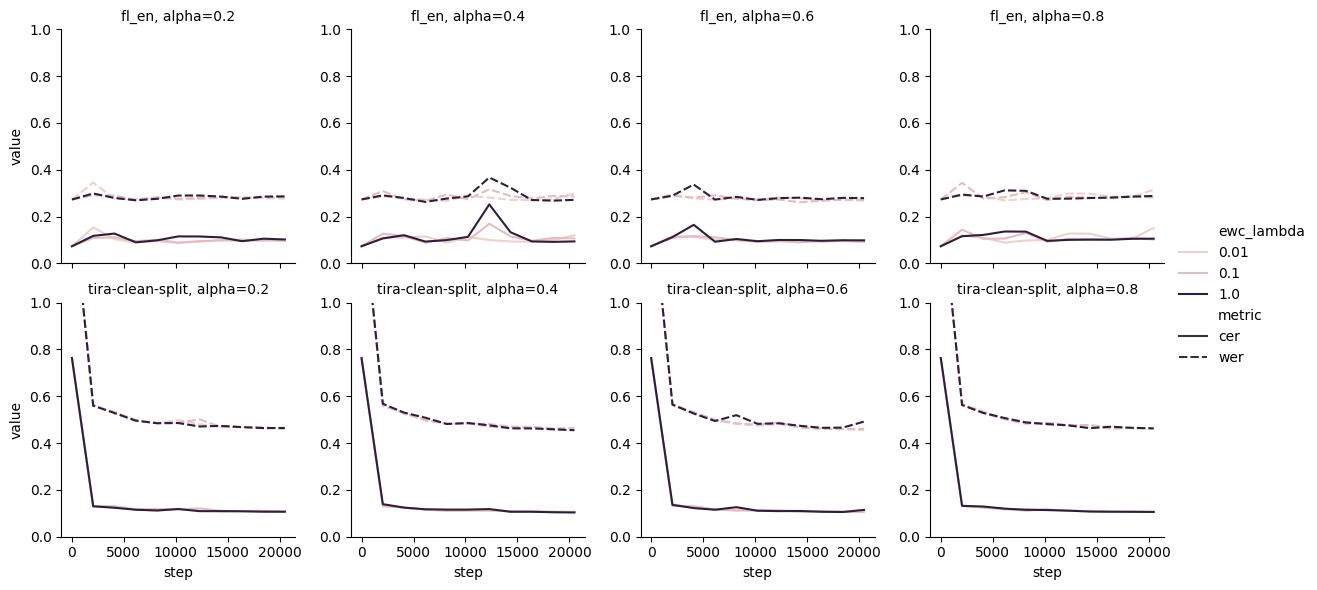

In [6]:
g = sb.FacetGrid(
    df[
        (df['dataset'].isin(['fl_en', 'tira-clean-split'])) &
        (df['metric']!='') &
        (df['lang_prompt']=='croatian')# &
        # (df['LoRA'])
        # (df['ewc_lambda']>0)
    ],
    col='lid_loss_alpha',
    row='dataset',
    # hue='lid_loss_alpha',
    sharey=False,
)
g.map_dataframe(
    sb.lineplot,
    x='step',
    y='value',
    hue='ewc_lambda',
    errorbar=None,
    legend='full',
    style='metric',
)
g.set_titles('{row_name}, alpha={col_name}')
g.add_legend()
# g.set_title('Performance on English while decoding as Yoruba')
g.set(ylim=(0,1))
plt.show()

# Langtok selection + LID loss

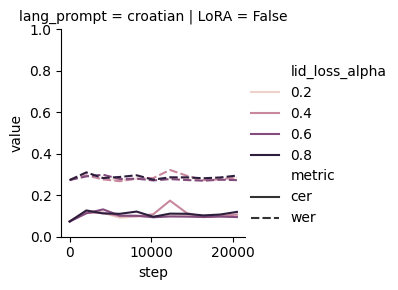

In [7]:
g = sb.FacetGrid(
    df[
        (df['dataset']=='fl_en') &
        (df['metric']!='') &
        (df['lang_prompt'].isin(['yoruba', 'swahili', 'croatian']))
    ],
    col='LoRA',
    row='lang_prompt',
    # hue='lid_loss_alpha',
    sharey=False,
)
g.map_dataframe(
    sb.lineplot,
    x='step',
    y='value',
    hue='lid_loss_alpha',
    errorbar=None,
    legend='full',
    style='metric',
)
g.add_legend()
# g.set_title('Performance on English while decoding as Yoruba')
g.set(ylim=(0,1))
plt.show()

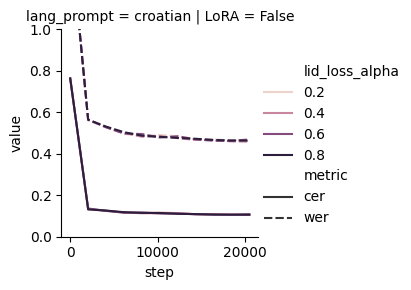

In [8]:
g = sb.FacetGrid(
    df[
        (df['dataset']=='tira-clean-split') &
        (df['metric']!='') &
        (df['lang_prompt'].isin(['yoruba', 'swahili', 'croatian']))
    ],
    col='LoRA',
    row='lang_prompt',
    # hue='lid_loss_alpha',
    sharey=False,
)
g.map_dataframe(
    sb.lineplot,
    x='step',
    y='value',
    hue='lid_loss_alpha',
    errorbar=None,
    legend='full',
    style='metric',
)
g.add_legend()
# g.set_title('Performance on English while decoding as Yoruba')
g.set(ylim=(0,1))
plt.show()

In [9]:
g = sb.FacetGrid(
    df[
        (df['dataset']=='HH20210312') &
        (df['metric']!='') &
        (df['lang_prompt'].isin(['yoruba', 'swahili', 'croatian']))
    ],
    col='LoRA',
    row='lang_prompt',
    # hue='lid_loss_alpha',
    sharey=False,
)
g.map_dataframe(
    sb.lineplot,
    x='step',
    y='value',
    hue='lid_loss_alpha',
    errorbar=None,
    legend='full',
    style='metric',
)
g.add_legend()
g.set(ylim=(0,1))
g.figure.suptitle('Performance on HH20210312 (in-domain)', size=16)
g.figure.subplots_adjust(top=.9)
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 0x0 with 0 Axes>

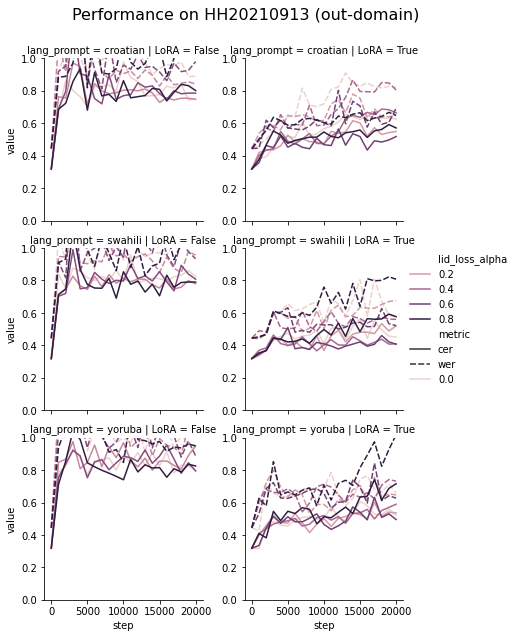

In [51]:
g = sb.FacetGrid(
    df[
        (df['dataset']=='HH20210913') &
        (df['metric']!='') &
        (df['lang_prompt'].isin(['yoruba', 'swahili', 'croatian']))
    ],
    col='LoRA',
    row='lang_prompt',
    # hue='lid_loss_alpha',
    sharey=False,
)
g.map_dataframe(
    sb.lineplot,
    x='step',
    y='value',
    hue='lid_loss_alpha',
    errorbar=None,
    legend='full',
    style='metric',
)
g.add_legend()
g.set(ylim=(0,1))
g.figure.suptitle('Performance on HH20210913 (out-domain)', size=16)
g.figure.subplots_adjust(top=.9)
plt.show()

In [52]:
df.loc[(df['tag']=='train/train_runtime')&df['LoRA'], 'value'].mean(), df.loc[(df['tag']=='train/train_runtime')&~df['LoRA'], 'value'].mean()

(42977.192708333336, 46647.522705078125)

# Langtoken experiments

In [53]:
df.loc[~df['embedding_distance_regularization_type'].isna(), 'dataset'].value_counts()


Series([], Name: count, dtype: int64)

In [54]:
g=sb.FacetGrid(
    df[
        (df['dataset'].isin(['tira-clean-split', 'fl_en'])) &
        (df['embedding_distance_regularization_type']!='') &
        (df['metric']!='')
    ],
    col='embedding_distance_regularization_type',
    row='dataset'
)
g.map_dataframe(
    sb.lineplot,
    x='step',
    y='value',
    hue='distance_regularization_lambda',
    errorbar=None,
    style='metric',
)
g.map(plt.axhline, y=1, color='red', linestyle='--')
g.set_titles('{col_name} {row_name}')
g.add_legend()
g.figure.suptitle('Performance on Tira while finetuning language prompt')
g.figure.subplots_adjust(top=.8)

ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x432 with 0 Axes>

Text(0.5, 1.0, 'Performance on Tira while finetuning language prompt')

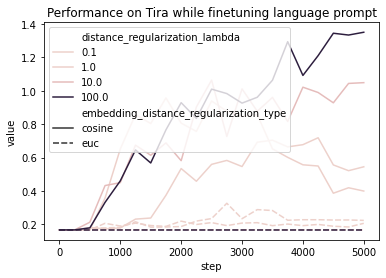

In [ ]:
ax=sb.lineplot(
    df[
        (df['dataset']=='fl_en') &
        (df['embedding_distance_regularization_type']!='') &
        (df['metric']!='')
    ],
    x='step',
    y='value',
    hue='distance_regularization_lambda',
    errorbar=None,
    style='embedding_distance_regularization_type',
)
# ax.set(ylim=(0, 6))
ax.set_title('Performance on Tira while finetuning language prompt')